# Targeted-IMSE applied with the change of variable in polar coordinates

In [11]:
data<-read.csv("data_visco.csv")
data_lasso <- read.csv("data_lasso.csv")
data_AIC <- read.csv("data_AIC.csv")

In [12]:
# We create a function that takes only the values for which the sum is under or equal to 100
Under_100 <-function(X){
    row<-vector()
    for (i in 1:dim(X)[1]){
        if (sum(X[i,-1])>100){
            row<-rbind(row,i)
        }
    }
    X<-X[-row,]
    return(X)
}

### Functions of change of variables

In [13]:
#install.packages("SphericalCubature")
library("SphericalCubature")

Le chargement a nécessité le package : cubature

Le chargement a nécessité le package : SimplicialCubature

Le chargement a nécessité le package : mvmesh

Le chargement a nécessité le package : rcdd

If you want correct answers, use rational arithmetic.
See the Warnings sections in help pages for
    functions that do computational geometry.

Le chargement a nécessité le package : rgl

Le chargement a nécessité le package : geometry

Le chargement a nécessité le package : abind



#### Change of  variables from a simplex to a N-sphere with the N-sphere coordinates

In [14]:
change_in_phi_from_x = function(x){ #We put in argument a matrix or a vector that takes n values in a simplex
    epsilon<-1e-9  # We had a little noise to insure that we can devide by 0
    X<-as.matrix(x[, -1]/100)
    X[which(X == NaN)] <- 0.
    for (i in 1:dim(X)[1]){   #To ensure that we each row is equal to 1 to remove the noise in the column with the highest values in it
        X[ i,23] <- X[ i,23] - (sum(X[i, ]==0.))*epsilon
    }
    X[which(X == 0.)] <- epsilon
    Y<-sqrt(X) #We do a first change of variables y²=x eq y=sqrt(x)
    Y[is.na(Y)] <- 0  #If we have some Nan in our matrix we replace them by zeros
    return(cbind(x[,1],t(as.matrix(rect2polar(t(Y))$phi))))
}

#### Change of  variables from a N-sphere to an simplex with the N-sphere coordinates

In [24]:
#This change of variable is only for a VECTOR
change_in_x_from_phi = function(phi){ #We put in argument vector that takes n-1 values of angles in [0, pi/2]
    Phi=as.matrix(phi)
    r=rep(1,dim(Phi)[1])  #To realize our change of variables considered in the function polar2rect in R it needs to take a radius equals to 1 
    new<-(t(polar2rect(r, t(Phi))))**2  # We realize the change of variables such that f.e. x_1=cos²(theta_1)
    new[which(new<1e-4)]<-0   #We obtain sometimes values of order 1e-5 we replace it by 0
    return (as.matrix(new*100))
}


### Targeted IMSE

In [16]:
library("KrigInv") #Pour t-IMSE
library("nloptr") #Pour la fonction d'optimisation Cobyla

In [20]:
#t-IMSE STANDARD APPLIQUEE AUX DONNEES 

d = dim(data_lasso)[2]
print(d)
N = 10*d
s = 0
data_Lasso_reduced = change_in_phi_from_x(data_lasso[1:N,-1])
data_Lasso_reduced=cbind(log(data_lasso[,1]),data_Lasso_reduced)
shape = c(dim(data_Lasso_reduced[, -1]))
print(shape)
noise = matrix(runif(prod(shape), min=0.0001, max=0.002),nrow=N)

mod = km(formula = ~1, design = data_Lasso_reduced[,-1]+noise, response = data_Lasso_reduced[,1])


lowerbound = as.vector(rep(0, dim(data_Lasso_reduced[, -1])[2]))
upperbound = as.vector(rep(pi/2, dim(data_Lasso_reduced[, -1])[2]))
max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=log(400))$par


[1] 30


Warning message in sqrt(X):
“Production de NaN”
Warning message in cbind(log(data_lasso[, 1]), data_Lasso_reduced):
“number of rows of result is not a multiple of vector length (arg 1)”


[1] 300  28

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.003745067 0.9873926 2.090869 0.1668312 0.003763582 0.7362698 0.1371617 0.003794793 0.003763235 0.337793 0.003780273 0.0037845 1.625261 0.003778642 1.135595 0.7172187 0.2653063 0.00378554 1.679722 0.003788374 0.2732784 0.003786057 2.187862 0.003767535 0.930844 1.050793 1.234519 1.910451 
  - best initial criterion value(s) :  -634.1381 

N = 28, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       634.14  |proj g|=       1.3464
At iterate     1  f =       438.38  |proj g|=        1.4259


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28
0.8016549,0.280966,1.204061,1.04764,0.2934157,0.918883,1.463552,1.145187,0.4264287,0.1305101,⋯,0.8572862,1.393888,1.063766,1.266699,0.9610131,0.9965617,1.285838,0.9060449,1.011973,0.08801614


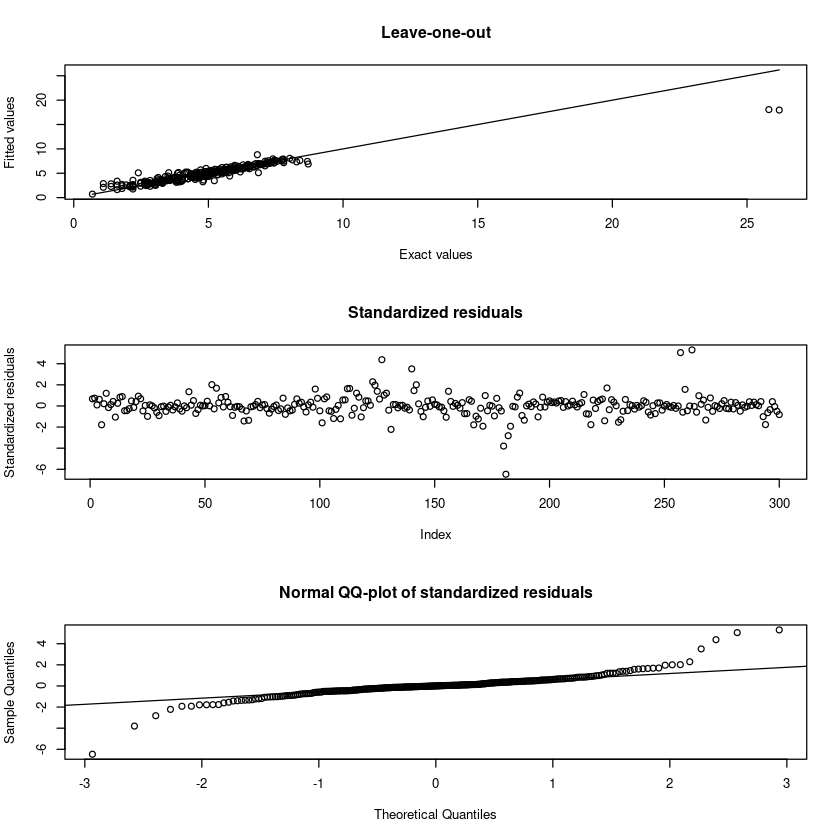

In [21]:
plot(mod)

In [25]:
phi=max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=log(400))$par
phi



Sun May 15 15:01:14 2022
Domains:
 0.000000e+00   <=  X1   <=    1.570796e+00 
 0.000000e+00   <=  X2   <=    1.570796e+00 
 0.000000e+00   <=  X3   <=    1.570796e+00 
 0.000000e+00   <=  X4   <=    1.570796e+00 
 0.000000e+00   <=  X5   <=    1.570796e+00 
 0.000000e+00   <=  X6   <=    1.570796e+00 
 0.000000e+00   <=  X7   <=    1.570796e+00 
 0.000000e+00   <=  X8   <=    1.570796e+00 
 0.000000e+00   <=  X9   <=    1.570796e+00 
 0.000000e+00   <=  X10  <=    1.570796e+00 
 0.000000e+00   <=  X11  <=    1.570796e+00 
 0.000000e+00   <=  X12  <=    1.570796e+00 
 0.000000e+00   <=  X13  <=    1.570796e+00 
 0.000000e+00   <=  X14  <=    1.570796e+00 
 0.000000e+00   <=  X15  <=    1.570796e+00 
 0.000000e+00   <=  X16  <=    1.570796e+00 
 0.000000e+00   <=  X17  <=    1.570796e+00 
 0.000000e+00   <=  X18  <=    1.570796e+00 
 0.000000e+00   <=  X19  <=    1.570796e+00 
 0.000000e+00   <=  X20  <=    1.570796e+00 
 0.000000e+00   <=  X21  <=    1.570796e+00 
 0.000000e+00   <= 

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28
0.8016549,0.280966,1.204061,1.04764,0.2934157,0.918883,1.463552,1.145187,0.4264287,0.1305101,⋯,0.8572862,1.393888,1.063766,1.266699,0.9610131,0.9965617,1.285838,0.9060449,1.011973,0.08801614


In [27]:
change_in_x_from_phi(phi)
sum(change_in_x_from_phi(phi))

48.37462,47.65609,0.5103417,0.8634131,2.378417,0.07991979,0,0.02311964,0.09325802,0.01892187,⋯,0,0,0,0,0,0,0,0,0,0


[1] 99.9981

# Fonction jouet

In [28]:
fjouet.test<-function(x1, x2){
    return((x1-0.5)**2+(x2-0.5)**2)
}

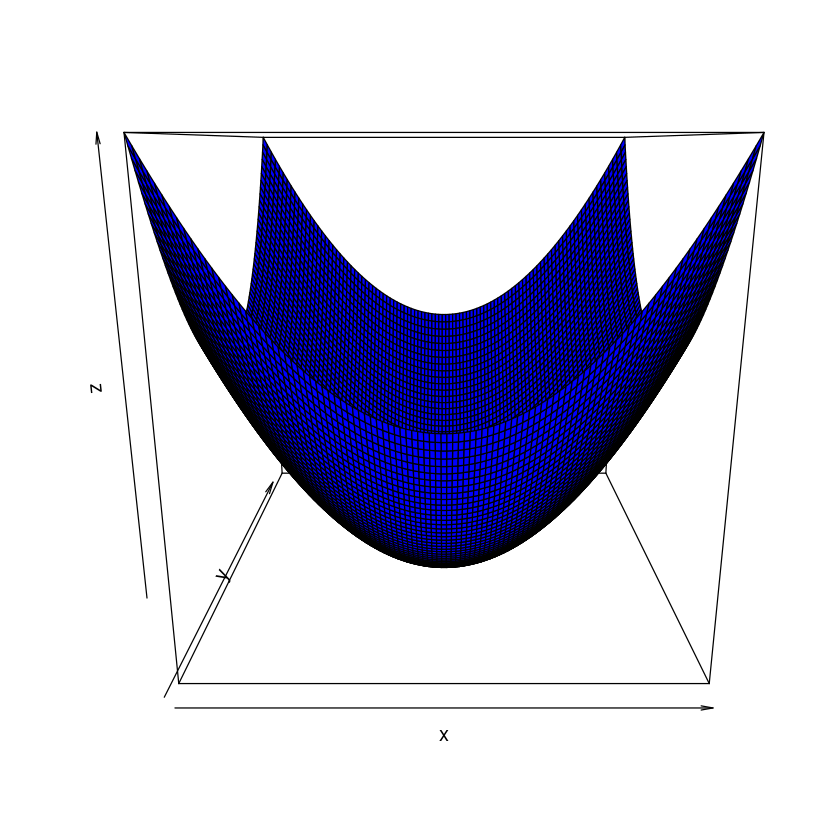

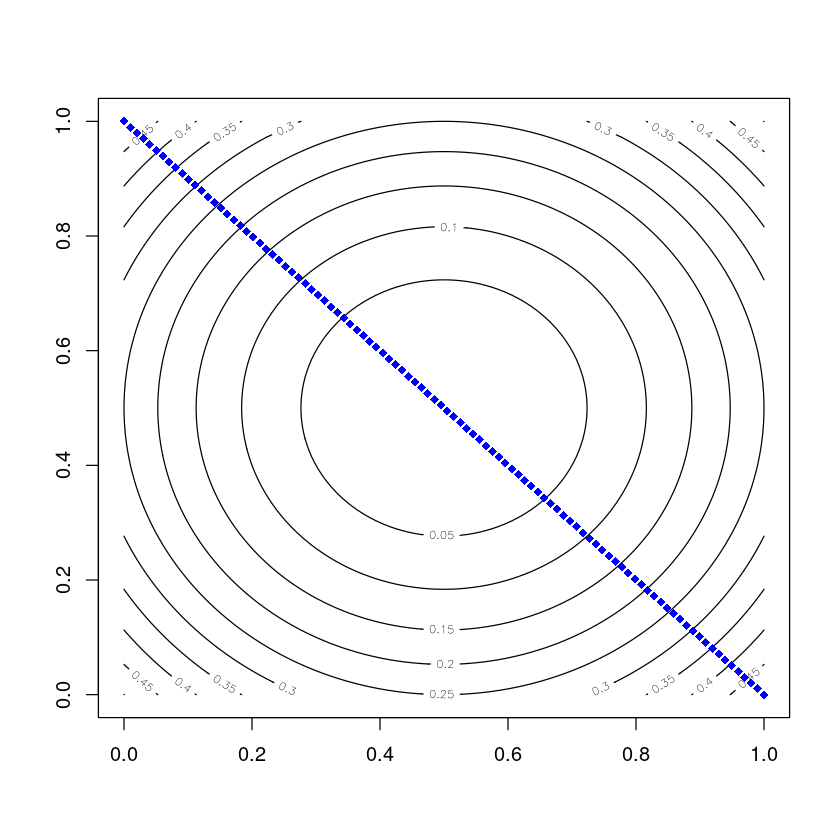

In [29]:
#x = c(0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9) 
#y=1-x

x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)

persp(x,y,z, col='blue')
contour(x,y,z)
lines(x, 1-x, pch=18, col="blue", type="b", lty=2)

In [31]:
jouet<-fjouet.test(0.2, 0.8)
jouet

[1] 0.18

In [32]:
test_change_in_phi_from_x = function(x){ #We put in argument a matrix or a vector that takes n values in a simplex
    X<-as.matrix(x[,-1])
    Y<-sqrt(X) #We do a first change of variables y²=x eq y=sqrt(x)
    Y[is.na(Y)] <- 0  #If we have some Nan in our matrix we replace them by zeros
    return(t(as.matrix(rect2polar((Y))$phi)))
}
test_change_in_phi_from_x(matrix(c(0.18, 0.2, 0.8), 1, 3))

1.107149


In [33]:
test_change_in_x_from_phi = function(phi){ #We put in argumennt a matrix or a vector that takes n-1 values of angles in [0, pi/2]
    Phi<-phi
    r=1  #To realize our change of variables considered in the function polar2rect in R it needs to take a radius equals to 1 
    new<-(t(polar2rect(r, (Phi))))**2  # We realize the change of variables such that f.e. x_1=cos²(theta_1)
    new[which(new<1e-4)]<-0   #We obtain sometimes values of order 1e-5 we replace it by 0
    return (new)
}

In [35]:
d = 2
N = 10*d

x <- seq(0,1,length.out=100)
y <- 1-x


donne <- cbind(x,y)
resp<- fjouet.test(donne[,1], donne[,2])
mat.donne<-as.data.frame(cbind(resp, donne))

mat.donne



data.change.var <- t(test_change_in_phi_from_x(mat.donne[1:N,-1]))

data.change.var=as.data.frame(cbind(mat.donne[1:N,1],data.change.var))

data.change.var
as.data.frame(data.change.var[,-1])
data.change.var[,1]
mod = km(formula = ~1, design = as.data.frame(data.change.var[,-1]), response = as.data.frame(data.change.var[,1]))

lowerbound = as.vector(rep(0, 1))
upperbound = as.vector(rep(pi/2, 1))



resp,x,y
<dbl>,<dbl>,<dbl>
0.50000000,0.00000000,1.0000000
0.48000204,0.01010101,0.9898990
0.46041220,0.02020202,0.9797980
0.44123049,0.03030303,0.9696970
0.42245689,0.04040404,0.9595960
0.40409142,0.05050505,0.9494949
0.38613407,0.06060606,0.9393939
0.36858484,0.07070707,0.9292929
0.35144373,0.08080808,0.9191919


Warning message in cbind(mat.donne[1:N, 1], data.change.var):
“number of rows of result is not a multiple of vector length (arg 1)”


V1,V2
<dbl>,<dbl>
0.5000000,1.3333978
0.4800020,1.3276721
0.4604122,1.3214590
0.4412305,1.3146855
0.4224569,1.3072625
0.4040914,1.2990799
0.3861341,1.2899999
0.3685848,1.2798468
0.3514437,1.2683930


"data.change.var[, -1]"
<dbl>
1.3333978
1.3276721
1.3214590
1.3146855
1.3072625
1.2990799
1.2899999
1.2798468
1.2683930


[1] 0.5000000 0.4800020 0.4604122 0.4412305 0.4224569 0.4040914 0.3861341
 [8] 0.3685848 0.3514437 0.3347107 0.3183859 0.3024691 0.2869605 0.2718600
[15] 0.2571676 0.2428834 0.2290072 0.2155392 0.2024793


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  1.10221 
  - best initial criterion value(s) :  83.61581 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -83.616  |proj g|=      0.31229
At iterate     1  f =      -83.628  |proj g|=      0.032401
At iterate     2  f =      -83.628  |proj g|=     0.0052213
At iterate     3  f =      -83.628  |proj g|=    7.3775e-05
At iterate     4  f =      -83.628  |proj g|=    7.3775e-05

iterations 4
function evaluations 16
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 7.37747e-05
final function value -83.6276

F = -83.6276
   in the last line search
fin

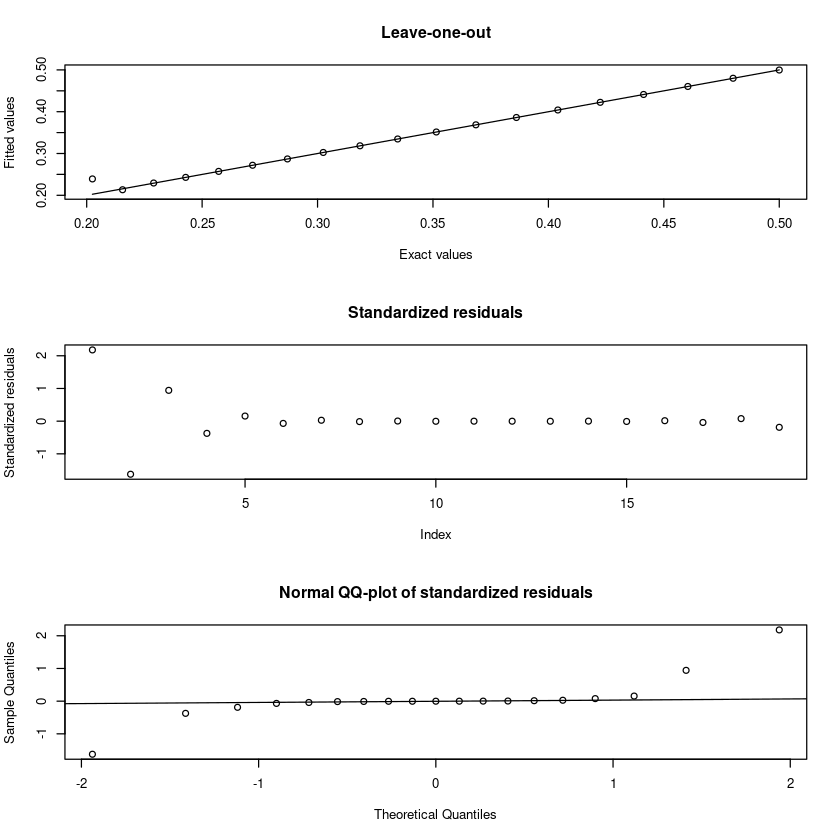

In [36]:
plot(mod)

In [37]:
eps <- 1e-3
theta=max_infill_criterion(lower=eps, upper = pi/2-eps, method="tmse", model=mod, T=0.02)$par



Sun May 15 15:05:56 2022
Domains:
 1.000000e-03   <=  X1   <=    1.569796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	7.292979e-01
      1 	7.343627e-01
      2 	7.349832e-01
      3 

In [53]:
fun <- function(phi){
    x <- test_change_in_x_from_phi(phi)
    fjouet.test(x[1], x[2])
}

In [54]:
optimcontrol <- list(method="genoud",pop.size=50)
obj1 <- EGI(T=0.18, model=mod, method="tmse", iter=10, fun = fun, 
           lower=eps, upper=pi/2 - eps, optimcontrol=optimcontrol)  #il faut retoruver 0.4 et 0.6



Sun May 15 15:21:40 2022
Domains:
 1.000000e-03   <=  X1   <=    1.569796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	4.078336e-02
      1 	4.087845e-02
      2 	4.088514e-02
      3 

In [41]:
obj1$par

data.change.var....1.
0.0010000
0.3498036
0.5546145
0.4412836
0.7279810
0.1758859
0.4861501
1.5697963
0.9878690
0.2715211


In [43]:
testt<-test_change_in_x_from_phi(0.2715211)
testt
fjouet.test(testt[1], testt[2])

0.9280703,0.07192969


[1] 0.3664884

In [44]:
obj1$value

"data.change.var[, 1]"
0.499999000
0.292685314
0.099169158
0.201720759
0.006564537
0.440638635
0.158710093
0.499999000
0.077604268
0.366488346


In [45]:
obj2 <- EGI(T=0.02, model=mod, method="tmse", iter=10, fun = fun, 
           lower=eps, upper=pi/2 - eps, optimcontrol=optimcontrol)  #il faut retrouver 0.2 et 0.8



Sun May 15 15:08:45 2022
Domains:
 1.000000e-03   <=  X1   <=    1.569796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	7.292979e-01
      1 	7.343627e-01
      2 	7.349832e-01
      3 

In [46]:
obj2$par
obj2$value

data.change.var....1.
0.0010000
0.3596491
0.5620560
0.6425198
0.1794926
0.6802571
0.4761234
0.6925827
1.5697963
0.7082602


"data.change.var[, 1]"
0.49999900
0.28295380
0.09330228
0.03972920
0.43828561
0.02178533
0.16811537
0.01703241
0.49999900
0.01180640


In [47]:
obj3 <- EGI(T=0.0578, model=mod, method="tmse", iter=10, fun = fun, 
           lower=eps, upper=pi/2 - eps, optimcontrol=optimcontrol)  #il faut retrouver 0.33 et 0.67



Sun May 15 15:09:14 2022
Domains:
 1.000000e-03   <=  X1   <=    1.569796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	7.353609e-01
      1 	7.404329e-01
      2 	7.410544e-01
      3 

In [48]:
obj3$par
obj3$value

data.change.var....1.
0.0010000
0.3581630
0.5623474
0.6341509
0.6704222
0.1826775
0.7116543
0.4760269
0.7392360
1.5697963


"data.change.var[, 1]"
0.49999900
0.28442637
0.09307538
0.04437292
0.02597619
0.43617516
0.01079768
0.16820652
0.00424979
0.49999900
